# Parameter scan for the LHC data set

In [25]:
import sys
import numpy as np
import optuna
import pickle
from matplotlib import pyplot as plt
import pandas as pd
from scipy.stats import gmean


In [5]:
studies = []
for i in range(50):
    try:
        studies.append(pickle.load(open(f"../data/paramscan/paramscan_{i}.pickle", "rb")))
    except FileNotFoundError as e:
        print(f"Param scan run {i} is missing")       
                       
trials = [study.trials_dataframe() for study in studies]


Param scan run 40 is missing
Param scan run 41 is missing
Param scan run 42 is missing
Param scan run 43 is missing
Param scan run 44 is missing
Param scan run 46 is missing
Param scan run 49 is missing


In [6]:
for i, trial in enumerate(trials):
    trial.index = [f"job_{i}_trial_{j}" for j in trial["number"]]
    trial.drop(["number", "system_attrs__number", "state"], axis=1)

results = pd.concat(trials)
results = results.sort_values(by="value", ascending=True)


In [7]:
results.columns

Index(['number', 'value', 'datetime_start', 'datetime_complete',
       'params_batchsize', 'params_clip', 'params_dropout', 'params_msefactor',
       'params_outerlayers', 'params_splinebins', 'params_splinerange',
       'params_weightdecay', 'system_attrs__number', 'state'],
      dtype='object')

In [12]:
np.percentile?

Signature:
np.percentile(
    a,
    q,
    axis=None,
    out=None,
    overwrite_input=False,
    interpolation='linear',
    keepdims=False,
)
Docstring:
Compute the q-th percentile of the data along the specified axis.

Returns the q-th percentile(s) of the array elements.

Parameters
----------
a : array_like
    Input array or object that can be converted to an array.
q : array_like of float
    Percentile or sequence of percentiles to compute, which must be between
    0 and 100 inclusive.
axis : {int, tuple of int, None}, optional
    Axis or axes along which the percentiles are computed. The
    default is to compute the percentile(s) along a flattened
    version of the array.

    .. versionchanged:: 1.9.0
        A tuple of axes is supported
out : ndarray, optional
    Alternative output array in which to place the result. It must
    have the same shape and buffer length as the expected output,
    but the type (of the output) will be cast if necessary.
overwrite_input : b

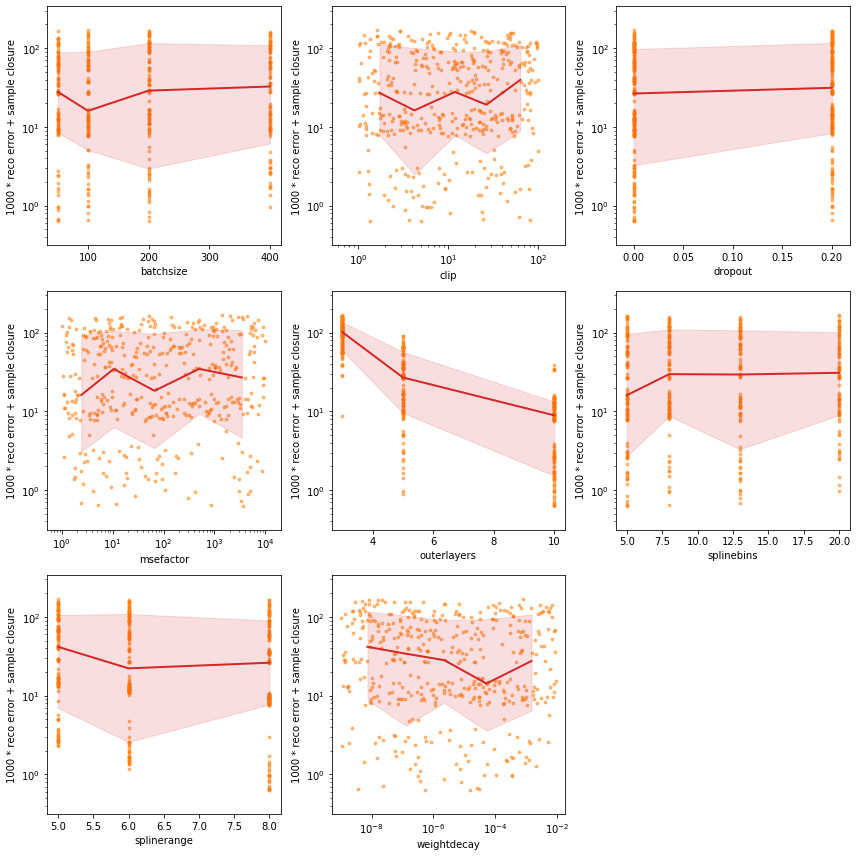

In [37]:
params = [c.replace("params_", "") for c in results.columns if "params_" in c]
n = len(params)
ncols = 3
nrows = (n - 1) // ncols + 1

plt.figure(figsize=(ncols * 4, nrows * 4))

for i, param in enumerate(params):
    x, y = results[f"params_{param}"], results["value"]
    
    ax = plt.subplot(nrows, ncols, i+1)
    plt.scatter(x, y, s=8., c="C1", alpha=0.5)
    plt.xlabel(param)
    plt.ylabel("1000 * reco error + sample closure")
    
    if param in ["clip", "msefactor", "weightdecay"]:
        boundaries = np.percentile(x, np.linspace(0., 100., 6))
    elif param == "batchsize":
        boundaries = [0, 75, 125, 300, 1000]
    elif param == "dropout":
        boundaries = [-0.1, 0.1, 0.3]
    elif param == "outerlayers":
        boundaries = [0, 4, 8, 11]
    elif param == "splinebins":
        boundaries = [0, 6, 10, 18, 30]
    elif param == "splinerange":
        boundaries = [0, 5.5, 7, 11]
    else:
        raise ValueError(param)
    
    x_means = [np.median(x[(x > min_)&(x < max_)]) for min_, max_ in zip(boundaries[:-1], boundaries[1:])]
    y_means = [np.median(y[(x > min_)&(x < max_)]) for min_, max_ in zip(boundaries[:-1], boundaries[1:])]
    y_low = [np.percentile(y[(x > min_)&(x < max_)], 16) for min_, max_ in zip(boundaries[:-1], boundaries[1:])]
    y_high = [np.percentile(y[(x > min_)&(x < max_)], 84) for min_, max_ in zip(boundaries[:-1], boundaries[1:])]
    plt.fill_between(x_means, y_low, y_high, color="C3", alpha=0.15)
    plt.plot(x_means, y_means, c="C3", lw=2.0)
    
    plt.ylim(0.5 * results["value"].min(), 2.*results["value"].max())
    plt.yscale("log")
    if param in ["clip", "msefactor", "weightdecay"]:
        plt.xscale("log")
        plt.xlim(0.5 * results[f"params_{param}"].min(), 2.*results[f"params_{param}"].max())
    
plt.tight_layout()
plt.savefig("../figures/lhc_paramscan.pdf")
